In [473]:
from pathlib import Path
from collections import Counter
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from datetime import datetime
import calendar
import math
from sklearn.metrics import mean_squared_error as mse

In [5]:
DATA_PATH = Path.cwd().parent.joinpath('data', 'processed', 'three_factor_model.txt')

In [6]:
df = pd.read_csv(DATA_PATH, delimiter = "\t")

In [7]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,5.860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,5.860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,1.736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,1.551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,1.219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08


In [8]:
df["Price_tb"] = df["Price_tb"]/100

In [9]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,0.05860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,0.05860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,0.01736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,0.01551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,0.01219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08


In [10]:
#excess is market excess
df.rename(columns = {"excess":"mkt_excess"}, inplace = True)

In [11]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,mkt_excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,0.05860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,0.05860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,0.01736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,0.01551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,0.01219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08


In [149]:
##changing first value of chng for LEA and VC to nan
df[df.tic == "VC"]
df.at[10025,"chng"] = np.nan


nan

In [152]:
df[df.tic == "LEA"]
df.at[5631,"chng"] = np.nan

In [374]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11885 entries, 0 to 11915
Data columns (total 17 columns):
datadate        11885 non-null object
tic             11885 non-null object
conm            11885 non-null object
prccq           11883 non-null float64
chng            11650 non-null float64
chng_cs         11885 non-null float64
mkt_excess      11885 non-null float64
Price_tb        11885 non-null float64
book_value      11691 non-null float64
bv_per_share    11691 non-null float64
ptb             11687 non-null float64
cshoc           11881 non-null float64
prccd           11885 non-null float64
prcod           9883 non-null float64
mkvaltq         11882 non-null float64
SMB value       11885 non-null float64
HML value       11885 non-null float64
dtypes: float64(14), object(3)
memory usage: 1.6+ MB


In [172]:
#deleting NHTC// NOT DOING THIS
#df.drop(df[df.tic == "NHTC"].index, inplace = True)

In [12]:
#need to make column of chng - tbill --> stock excess. probs can be done in temp files for OLS

#need to create a separate object to tabulate small versus big stocks and each time period, 
#since stocks can grow and become big
#
# first step: get mkt value and returns of all stocks available at each quarter q 
# second step: get percentiles at each time in terms of q
# third step: take returns of bottom 10% less top 10% (regular average) to get factor at each time step q

# need similar process for HML, tbd

In [13]:
##making SMB
dat = {'datadate':[],'SMB value':[]}
SMB = pd.DataFrame(data = dat)
j = 0
for i in np.unique(df["datadate"]):
    temp = df[df.datadate == i][["chng","mkvaltq"]]
 
    ten = np.nanpercentile(temp["mkvaltq"],10)
    ninety = np.nanpercentile(temp["mkvaltq"],90)
    small = temp[temp["mkvaltq"]< ten]
    big = temp[temp["mkvaltq"]> ninety]
    small_rets = np.nanmean(small["chng"])
    big_rets = np.nanmean(big["chng"])
    factor =  small_rets - big_rets
    SMB.loc[j] = [i,factor]
    j+=1

In [14]:
SMB.head()
#first row is 0 because all stocks on q1 have a nan change percent lol

,datadate,SMB value
0,2000-03-31,0.000000
1,2000-06-30,-0.193951
2,2001-12-31,0.161618
3,2002-09-30,0.028483
4,2002-12-31,0.138784


In [15]:
##making HML
dat = {'datadate':[],'HML value':[]}
HML = pd.DataFrame(data = dat)
j = 0
for i in np.unique(df["datadate"]):
    temp = df[df.datadate == i][["tic","chng","ptb"]]
 
    ten = np.nanpercentile(temp["ptb"],10)
    ninety = np.nanpercentile(temp["ptb"],90)
    value = temp[temp["ptb"]< ten]
    growth = temp[temp["ptb"]> ninety]
    val_rets = np.nanmean(value["chng"])
    growth_rets = np.nanmean(growth["chng"])
    factor =  val_rets - growth_rets
    HML.loc[j] = [i,factor]
    j+=1

In [16]:
HML.head()
##same thing with HML, first row isnt technically usable

,datadate,HML value
0,2000-03-31,0.000000
1,2000-06-30,0.032200
2,2001-12-31,0.014985
3,2002-09-30,-0.099567
4,2002-12-31,-0.100850


In [17]:
df = df.merge(SMB, how = "left", on = "datadate")

In [18]:
df = df.merge(HML, how = "left", on = "datadate")

In [19]:
df.head()

,datadate,tic,conm,prccq,chng,chng_cs,mkt_excess,Price_tb,book_value,bv_per_share,ptb,cshoc,prccd,prcod,mkvaltq,SMB value,HML value
0,2000-03-31,ABF,AIRBORNE INC,24.0000,NaN,-0.014137,-0.072737,0.05860,894267000.0,18.339048,1.308683,48763000.0,24.0000,NaN,1.170312e+09,0.000000,0.000000
1,2000-06-30,ABF,AIRBORNE INC,18.9375,-0.210938,0.008527,-0.050073,0.05860,884944000.0,18.054923,1.048883,49014000.0,18.9375,NaN,9.282026e+08,-0.193951,0.032200
2,2001-12-31,ABF,AIRBORNE INC,14.8300,0.552880,0.004970,-0.012390,0.01736,834216000.0,17.341926,0.855153,48104000.0,14.8300,NaN,7.133823e+08,0.161618,0.014985
3,2002-09-30,ABF,AIRBORNE INC,11.3400,-0.409375,-0.074990,-0.090500,0.01551,829688000.0,17.143377,0.661480,48397000.0,11.3400,NaN,5.488220e+08,0.028483,-0.099567
4,2002-12-31,ABF,AIRBORNE INC,14.8300,0.307760,0.002302,-0.009888,0.01219,839163000.0,17.329843,0.855749,48423000.0,14.8300,NaN,7.181131e+08,0.138784,-0.100850


In [173]:
factors = []
for tic in np.unique(df["tic"]):
    try:
        temp_df = df[df["tic"] == tic]
        temp_df = temp_df.reset_index(drop = True)
        temp_df = temp_df.dropna()
        Y = temp_df["chng"]-(temp_df["Price_tb"])
        X = temp_df[["mkt_excess","SMB value","HML value"]]
        model = OLS(Y,sm.tools.add_constant(X)).fit()
        factors.append((tic,model.params,model.pvalues,model.rsquared))
    except:
        continue

/Users/siddharthkantamneni/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/siddharthkantamneni/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/siddharthkantamneni/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/siddharthkantamneni/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/Users/siddharthkantamneni/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: 

In [174]:
##plot expected value versus actual returns of a couple stocks, some with at least one (hoepfully more)
#statisitically signifcaint betas and those with none
sig = []
insig = []
for i in factors:
    if all(ele < 0.15 for ele in i[2]):
        sig.append(i)

    if all(ele > 0.5 for ele in i[2]):
        insig.append(i)

In [175]:
X = df[["datadate","tic","chng","mkt_excess","SMB value","HML value","Price_tb"]]

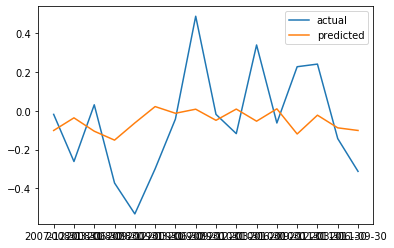

FACE MSE: 0.07255884828239291


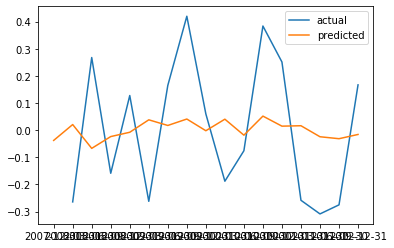

HOGS MSE: 0.05993112848145078


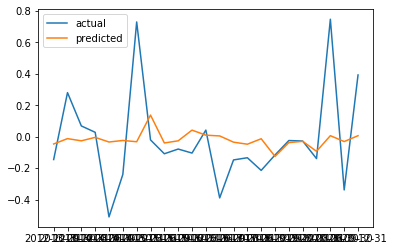

NGVC MSE: 0.09158650507833134


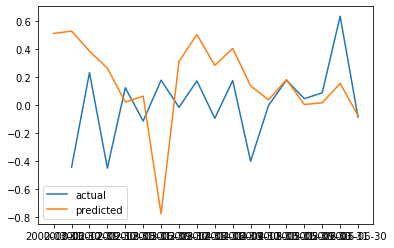

OATS MSE: 0.19996576583251496


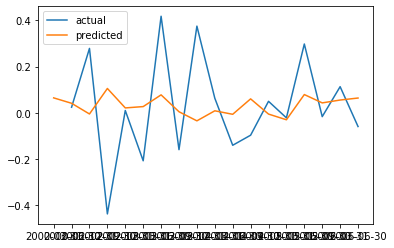

OO MSE: 0.050586956896071886


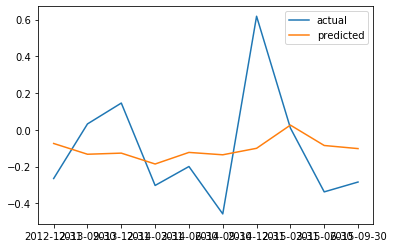

RNDY MSE: 0.09314537784018566


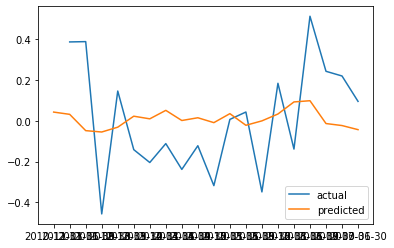

SODA MSE: 0.06829432070378616


In [176]:
for i in insig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]
    
    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    plt.plot(temp["datadate"],temp["chng"]-temp['Price_tb'])
    plt.plot(temp["datadate"],expct_exc_rets)
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0],'MSE: '+str(mse(temp['chng'][1:]-temp['Price_tb'][1:],expct_exc_rets[1:])))
    

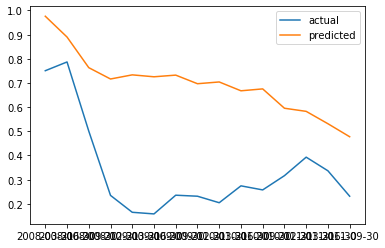

FACE MSE: 0.07255884828239291


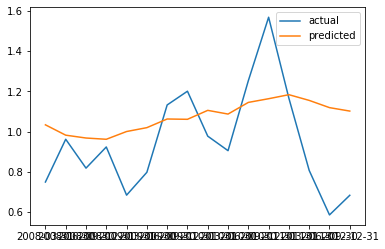

HOGS MSE: 0.05993112848145078


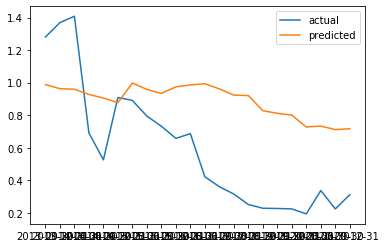

NGVC MSE: 0.09158650507833134


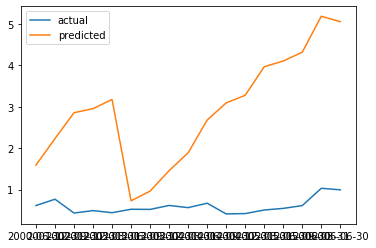

OATS MSE: 0.19996576583251496


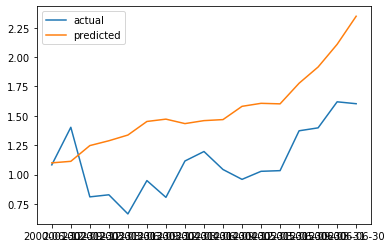

OO MSE: 0.050586956896071886


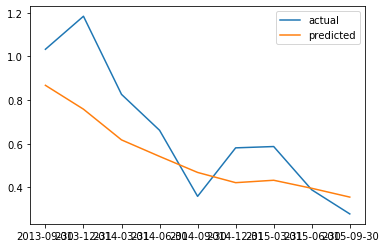

RNDY MSE: 0.09314537784018566


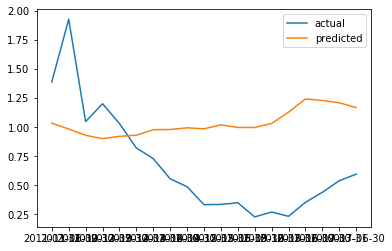

SODA MSE: 0.06829432070378616


In [177]:
for i in insig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]
    
    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    gross_expct = 1+np.array(expct_exc_rets[1:])+temp['Price_tb'][1:]
    gross_actual = temp["chng"][1:]+1
    
    
    plt.plot(temp["datadate"][1:],gross_actual.cumprod())
    plt.plot(temp["datadate"][1:],gross_expct.cumprod())
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0],'MSE: '+str(mse(temp['chng'][1:]-temp['Price_tb'][1:],expct_exc_rets[1:])))
    

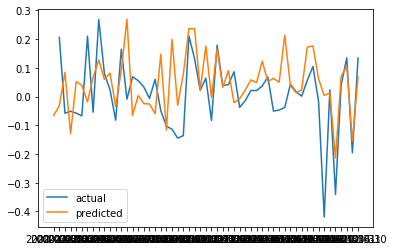

BTI MSE: 0.016426248858923798


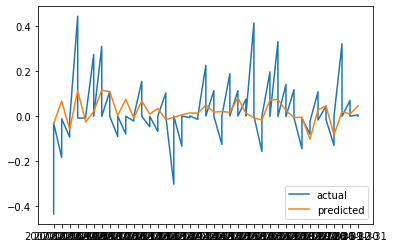

CENTA MSE: 0.014999933817817834


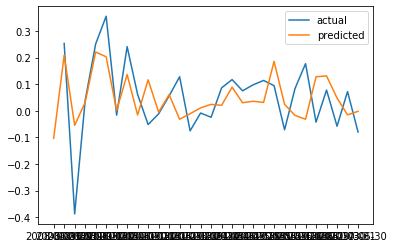

DPS MSE: 0.012454098928501972


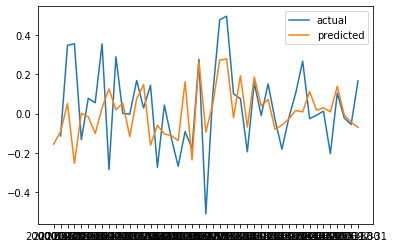

JAH MSE: 0.038164944744870304


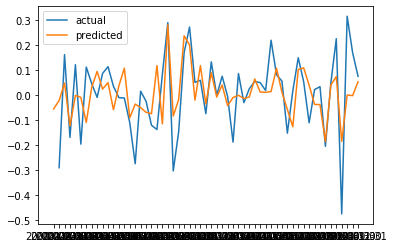

LEG MSE: 0.0157742201875323


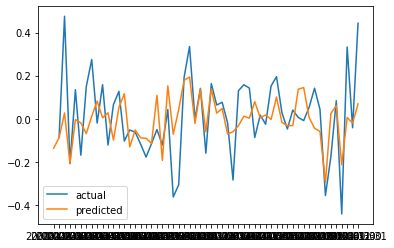

MHK MSE: 0.02533142758838758


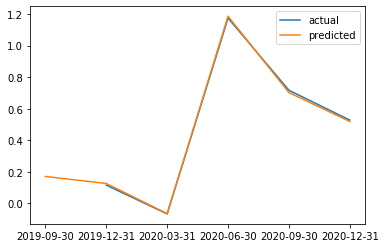

PTON MSE: 0.00010653643220904496


In [178]:
for i in sig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]
    
    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    plt.plot(temp["datadate"],temp["chng"]-temp['Price_tb'])
    plt.plot(temp["datadate"],expct_exc_rets)
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0],'MSE: '+str(mse(temp['chng'][1:]-temp['Price_tb'][1:],expct_exc_rets[1:])))

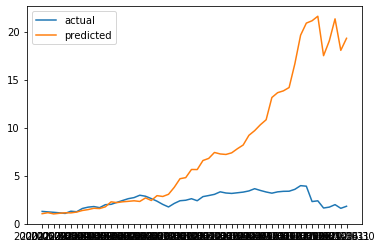

BTI MSE: 0.016426248858923798


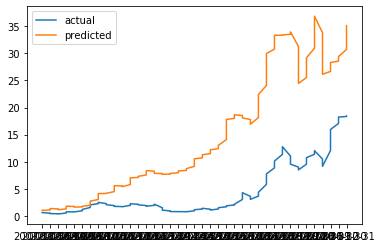

CENTA MSE: 0.014999933817817834


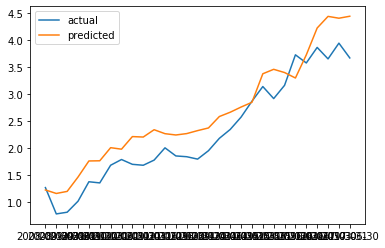

DPS MSE: 0.012454098928501972


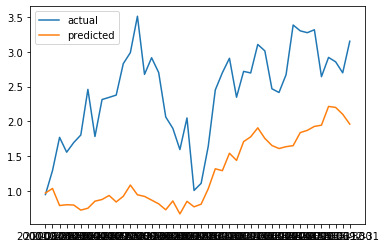

JAH MSE: 0.038164944744870304


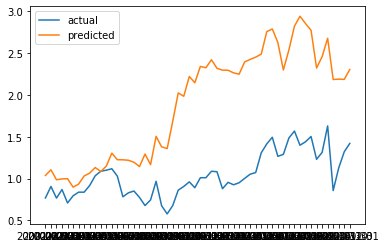

LEG MSE: 0.0157742201875323


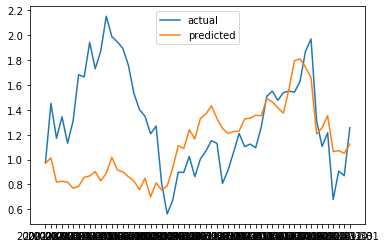

MHK MSE: 0.02533142758838758


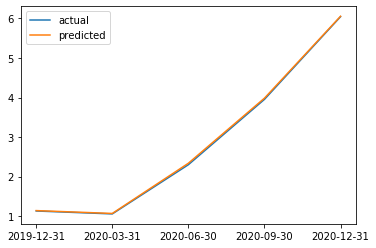

PTON MSE: 0.00010653643220904496


In [179]:
for i in sig:
    tic = i[0]
    temp = X[X["tic"]==tic]
    expct_exc_rets = []
    alpha = i[1][0]
    beta_ex = i[1][1]
    beta_smb = i[1][2]
    beta_hml = i[1][3]
    
    for j in range(len(temp)):
        ret = beta_ex*temp.iloc[j]["mkt_excess"]+beta_smb*temp.iloc[j]["SMB value"]+\
        beta_hml*temp.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp["datadate"].reset_index()
    gross_expct = 1+np.array(expct_exc_rets[1:])+temp['Price_tb'][1:]
    gross_actual = temp["chng"][1:]+1
    
    
    plt.plot(temp["datadate"][1:],gross_actual.cumprod())
    plt.plot(temp["datadate"][1:],gross_expct.cumprod())
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp["tic"].iloc[0],'MSE: '+str(mse(temp['chng'][1:]-temp['Price_tb'][1:],expct_exc_rets[1:])))
    

In [180]:
##baskets = {datadate1:{short:[],long:[]},}
baskets = {}
for t in np.unique(df["datadate"]):
    
    dat = {}
    
    smb = df[df['datadate']==t]["SMB value"].iloc[0]
    hml = df[df['datadate']==t]["HML value"].iloc[0]
    mkt_exc = df[df['datadate']==t]["mkt_excess"].iloc[0]
    
    temp_rets = pd.DataFrame(columns = ['tic','exp exc ret'])
    q = 0
    
    for j in factors:
        try:
            if np.isnan(j[2]).any():
                continue
            tic = j[0]
            alpha = j[1][0]
            beta_ex = j[1][1]
            beta_smb = j[1][2]
            beta_hml = j[1][3]
            exp_exc_ret = alpha + beta_ex*mkt_exc+beta_smb*smb+beta_hml*hml
            temp_rets.loc[q] = [tic,exp_exc_ret]
            q+=1
        except:
            continue
    temp_rets.dropna(inplace = True)
    x = temp_rets.sort_values("exp exc ret")[:10].reset_index(drop = True)
    y = temp_rets.sort_values("exp exc ret",ascending = False)[:10].reset_index(drop = True)
    dat["short"] = x
    dat["long"] = y
    baskets[t] = dat
        
        

In [181]:
baskets[t]

{'short':      tic  exp exc ret
 0   DOLE    -0.346572
 1   CHBT    -0.179859
 2   RNDY    -0.159659
 3   BYND    -0.147099
 4   CSKI    -0.140663
 5   HFFG    -0.097617
 6    WWY    -0.091083
 7   ENZY    -0.060381
 8    SFS    -0.050255
 9  ARDNA    -0.036891, 'long':     tic  exp exc ret
 0  CELH     2.266735
 1    GM     0.657893
 2  ROKU     0.609441
 3  ADNT     0.577917
 4  PTON     0.518917
 5  BARE     0.493153
 6   KTB     0.482339
 7  DLPH     0.478544
 8   VNE     0.436591
 9   WOW     0.428924}

In [182]:
for j in factors:
    if j[0] == "CELH":
        print(j)
        break

('CELH', const         0.706402
mkt_excess    6.648677
SMB value     5.681302
HML value    -7.814699
dtype: float64, const         0.565971
mkt_excess    0.759301
SMB value     0.086187
HML value     0.494671
dtype: float64, 0.37388758152860957)


In [192]:
np.unique(df[df.chng > 1].tic)

array(['ABC', 'ADNT', 'ADY', 'AIPC', 'ANDE', 'AXL', 'BARE', 'BC', 'BEAM',
       'BYND', 'BZH', 'CAA', 'CELH', 'COTY', 'CPG', 'CPRI', 'CROX', 'CTB',
       'DAN', 'DECK', 'F', 'GM', 'GPRO', 'HLF', 'ICON', 'IPAR', 'JAKK',
       'JBSS', 'JNY', 'JSDA', 'LEXR', 'LFVN', 'MED', 'MGPI', 'MIDD',
       'MOD', 'MTEX', 'MTH', 'NATR', 'NLS', 'NTRI', 'PPC', 'PRMW', 'PTON',
       'REV', 'SEED', 'SKX', 'SNMX', 'STKL', 'SUP', 'SVM', 'TEN', 'TRW',
       'TSLA', 'TUP', 'USNA', 'WES', 'WOW', 'WRC'], dtype=object)

In [ ]:
### switching beta computation method

In [193]:
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

In [203]:
def int_sum(x):
    sum1 = 0
    for i in range(1,x+1):
        sum1+=i
    return sum1
##this sum becomes denominator of weights
##x should be length of weights ie number of time periods
##each element in weights will receive its appropriate portion such that the weights will sum to one
##ie each value (i-1)

In [204]:

print(model.summary())


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.207
Model:                            WLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     2.266
Date:                Thu, 15 Apr 2021   Prob (F-statistic):              0.105
Time:                        19:22:46   Log-Likelihood:                 24.015
No. Observations:                  29   AIC:                            -42.03
Df Residuals:                      26   BIC:                            -37.93
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mkt_excess     1.1650      0.724      1.609      0.1

In [194]:
##alpha = sum over all t w(t) * (exc_ret - sum over all j Bj *fj(t)) for a given factor

In [243]:
alf = 0
for i in range(len(w)):
    no = 0
    for j in range(len(model.params)):
        no+=X.iloc[i][j]*model.params[j]
    yes = (Y.iloc[i]-no)*w[i]
    alf+=yes

In [207]:
for j in model.params:
    print(j)

1.1649867998855779
0.07303461958434565
-0.15070316603295458


In [244]:
alf

0.025865287421418377

In [245]:
e_dps = []
for i in range(len(w)):
    kyo = Y.iloc[i] - alf
    no = 0
    for j in range(len(model.params)):
        no+=X.iloc[i][j]*model.params[j]
    kyo-=no
    e_dps.append(kyo)
    

In [246]:
np.mean(e_dps)

0.017518934346104065

In [474]:
##need to apply model to all stocks to get B
factors = pd.DataFrame(columns = ['Tic','Alpha','Beta_mkt_Exc','Beta_SMB','Beta_HML','p_MX','p_smb','p_hml','r2'])
delta = np.zeros(shape = (len(np.unique(df["tic"])),len(np.unique(df["tic"]))))
q = -1
for tic in np.unique(df["tic"]):
    try:
        q+=1
        temp_df = df[df["tic"] == tic]
        temp_df = temp_df.reset_index(drop = True)
        temp_df = temp_df.dropna()
        Y = temp_df["chng"]-(temp_df["Price_tb"])
        X = temp_df[["mkt_excess","SMB value","HML value"]]
        w = np.ones(temp_df.shape[0])
        denom = int_sum(len(w))
        for i in range(len(w)):
            w[i] += i
        w = w/denom
        model = sm.WLS(Y,X, weights = w).fit()
        alf = 0
        for i in range(len(w)):
            no = 0
            for j in range(len(model.params)):
                no+=X.iloc[i][j]*model.params[j]
            yes = (Y.iloc[i]-no)*w[i]
            alf+=yes
        
        e_i = []
        for i in range(len(w)):
            kyo = Y.iloc[i] - alf
            no = 0
            for j in range(len(model.params)):
                no+=X.iloc[i][j]*model.params[j]
            kyo-=no
            e_i.append(kyo)
        
        eii = 0
        for i in range(len(w)):
            eii+=w[i]*(e_i[i]**2)
        delta[q][q] = eii
        
        factors.loc[q] = [tic,alf,model.params[0],model.params[1],model.params[2],model.pvalues[0],model.pvalues[1],\
                         model.pvalues[2], model.rsquared]
        
    except Exception as e:
        continue

In [471]:
sig = []
insig = []
for i in range(len(factors)):
    if all(ele < 0.07 for ele in factors.iloc[i][["p_MX","p_smb","p_hml"]]):
        sig.append(i)

    if all(ele > 0.55 for ele in factors.iloc[i][["p_MX","p_smb","p_hml"]]):
        insig.append(i)

In [472]:
insig

[]

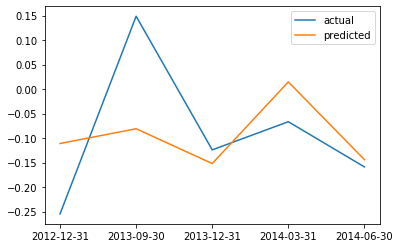

BNNY MSE: 0.015091059238337465 0.2787213507445083


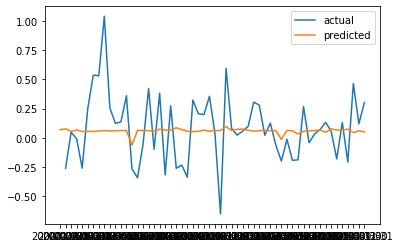

DECK MSE: 0.08249183721018599 0.005798581530082614


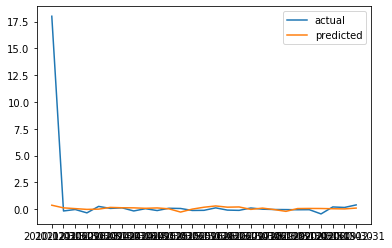

GM MSE: 0.05019852687656544 0.01562047150618584


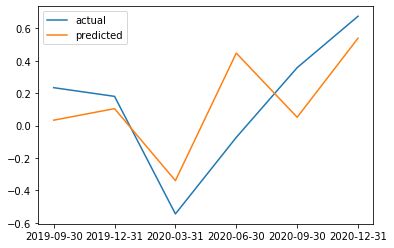

KTB MSE: 0.08612253999100558 0.4584795376021812


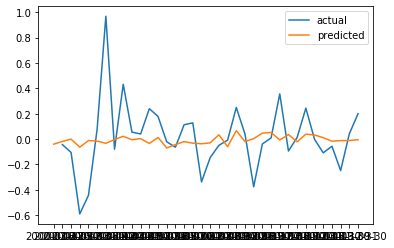

NAFC MSE: 0.06935678502840668 0.03232838719763398


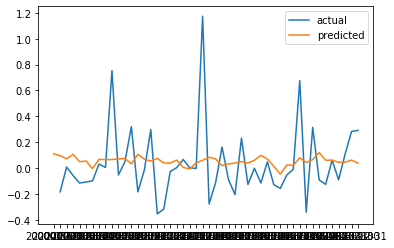

NATR MSE: 0.07773202666049234 0.01432604812434446


In [320]:
for i in insig:
    temp_row = factors.iloc[i]
    expct_exc_rets = []
    alpha = temp_row["Alpha"]
    beta_ex = temp_row["Beta_mkt_Exc"]
    beta_smb = temp_row["Beta_SMB"]
    beta_hml = temp_row["Beta_HML"]
    
    temp_df = df[df["tic"] == factors.iloc[i]["Tic"]]
    for j in range(len(temp_df)):
        ret = beta_ex*temp_df.iloc[j]["mkt_excess"]+beta_smb*temp_df.iloc[j]["SMB value"]+\
        beta_hml*temp_df.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp_df["datadate"].reset_index()
    plt.plot(temp_df["datadate"],temp_df["chng"]-temp_df['Price_tb'])
    plt.plot(temp_df["datadate"],expct_exc_rets)
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp_df["tic"].iloc[0],'MSE: '+str(mse(temp_df['chng'][1:]-temp_df['Price_tb'][1:],expct_exc_rets[1:])), temp_row["r2"])
    

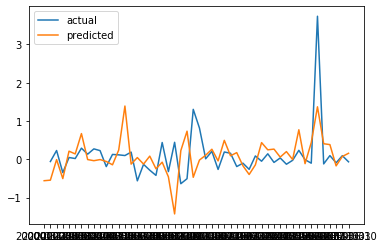

CAA MSE: 0.4178080195187092 0.29538400698650824


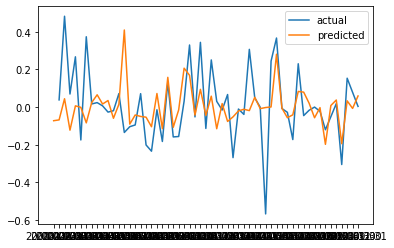

COLM MSE: 0.03207058711468134 0.29452231243245064


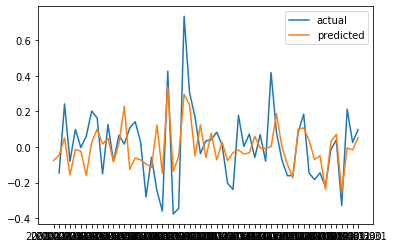

HNI MSE: 0.026159741565965473 0.4033528464870396


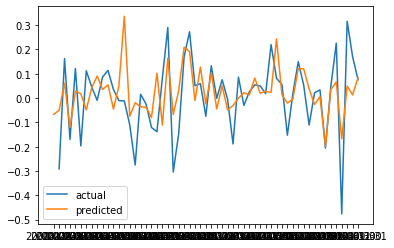

LEG MSE: 0.017186678196709344 0.32477346916852456


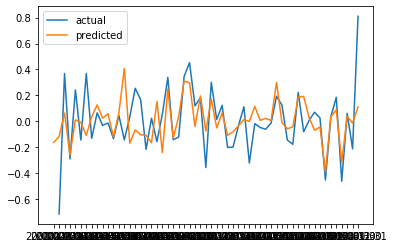

SHOO MSE: 0.04657543851636884 0.3732305707703847


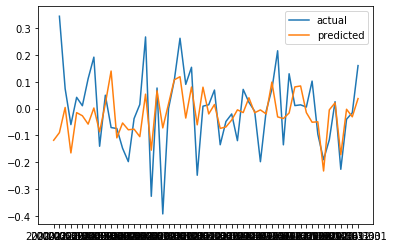

UVV MSE: 0.016056086961794173 0.3712683343853026


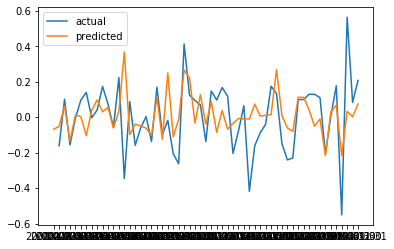

WWW MSE: 0.03370325190356343 0.2533534577985087


In [321]:
for i in sig:
    temp_row = factors.iloc[i]
    expct_exc_rets = []
    alpha = temp_row["Alpha"]
    beta_ex = temp_row["Beta_mkt_Exc"]
    beta_smb = temp_row["Beta_SMB"]
    beta_hml = temp_row["Beta_HML"]
    
    temp_df = df[df["tic"] == factors.iloc[i]["Tic"]]
    for j in range(len(temp_df)):
        ret = beta_ex*temp_df.iloc[j]["mkt_excess"]+beta_smb*temp_df.iloc[j]["SMB value"]+\
        beta_hml*temp_df.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
    dates = temp_df["datadate"].reset_index()
    plt.plot(temp_df["datadate"],temp_df["chng"]-temp_df['Price_tb'])
    plt.plot(temp_df["datadate"],expct_exc_rets)
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp_df["tic"].iloc[0],'MSE: '+str(mse(temp_df['chng'][1:]-temp_df['Price_tb'][1:],expct_exc_rets[1:])), temp_row["r2"])
    

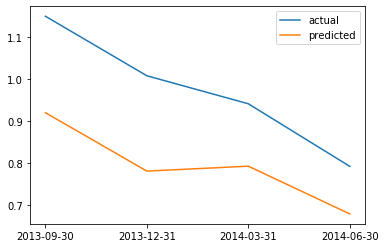

BNNY MSE: 0.015091059238337465


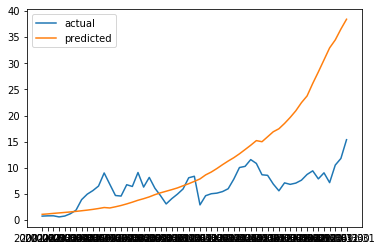

DECK MSE: 0.08249183721018599


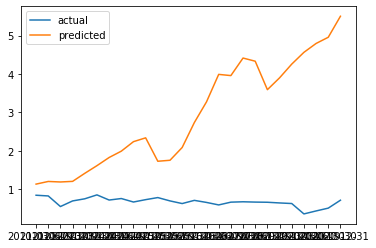

GM MSE: 0.05019852687656544


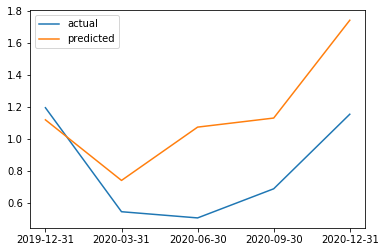

KTB MSE: 0.08612253999100558


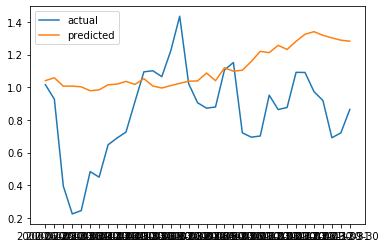

NAFC MSE: 0.06935678502840668


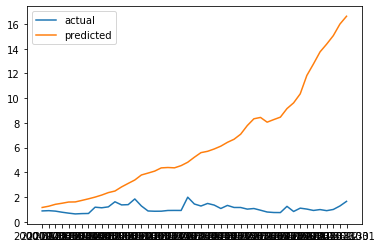

NATR MSE: 0.07773202666049234


In [316]:
for i in insig:
    temp_row = factors.iloc[i]
    expct_exc_rets = []
    alpha = temp_row["Alpha"]
    beta_ex = temp_row["Beta_mkt_Exc"]
    beta_smb = temp_row["Beta_SMB"]
    beta_hml = temp_row["Beta_HML"]
    
    temp_df = df[df["tic"] == factors.iloc[i]["Tic"]]
    for j in range(len(temp_df)):
        ret = beta_ex*temp_df.iloc[j]["mkt_excess"]+beta_smb*temp_df.iloc[j]["SMB value"]+\
        beta_hml*temp_df.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
        
    dates = temp["datadate"].reset_index()
    gross_expct = 1+np.array(expct_exc_rets[1:])+temp_df['Price_tb'][1:]
    gross_actual = temp_df["chng"][1:]+1
    
    
    plt.plot(temp_df["datadate"][1:],gross_actual.cumprod())
    plt.plot(temp_df["datadate"][1:],gross_expct.cumprod())
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp_df["tic"].iloc[0],'MSE: '+str(mse(temp_df['chng'][1:]-temp_df['Price_tb'][1:],expct_exc_rets[1:])))
    

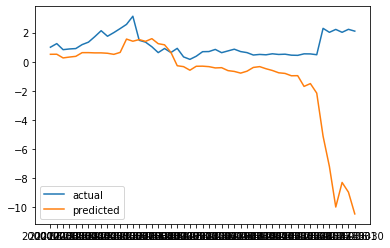

CAA MSE: 0.4178080195187092


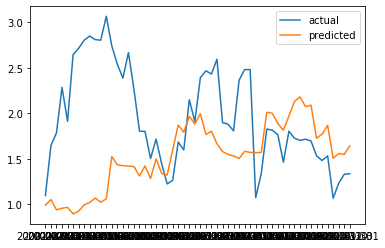

COLM MSE: 0.03207058711468134


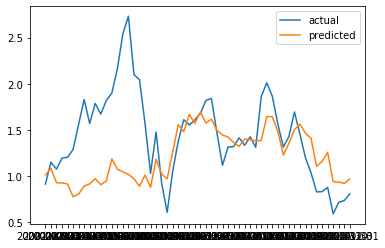

HNI MSE: 0.026159741565965473


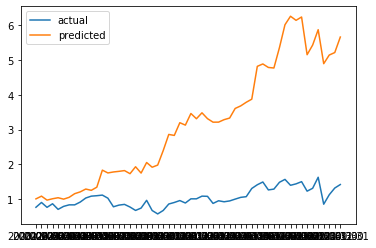

LEG MSE: 0.017186678196709344


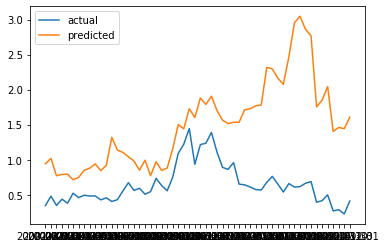

SHOO MSE: 0.04657543851636884


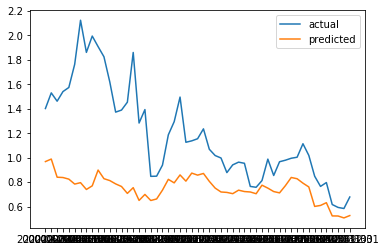

UVV MSE: 0.016056086961794173


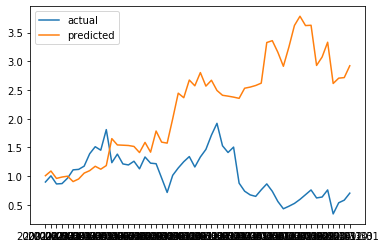

WWW MSE: 0.03370325190356343


In [317]:
for i in sig:
    temp_row = factors.iloc[i]
    expct_exc_rets = []
    alpha = temp_row["Alpha"]
    beta_ex = temp_row["Beta_mkt_Exc"]
    beta_smb = temp_row["Beta_SMB"]
    beta_hml = temp_row["Beta_HML"]
    
    temp_df = df[df["tic"] == factors.iloc[i]["Tic"]]
    for j in range(len(temp_df)):
        ret = beta_ex*temp_df.iloc[j]["mkt_excess"]+beta_smb*temp_df.iloc[j]["SMB value"]+\
        beta_hml*temp_df.iloc[j]["HML value"]+alpha
        expct_exc_rets.append(ret)
        
    dates = temp["datadate"].reset_index()
    gross_expct = 1+np.array(expct_exc_rets[1:])+temp_df['Price_tb'][1:]
    gross_actual = temp_df["chng"][1:]+1
    
    
    plt.plot(temp_df["datadate"][1:],gross_actual.cumprod())
    plt.plot(temp_df["datadate"][1:],gross_expct.cumprod())
    plt.legend(['actual', 'predicted'])
    plt.show()
    print(temp_df["tic"].iloc[0],'MSE: '+str(mse(temp_df['chng'][1:]-temp_df['Price_tb'][1:],expct_exc_rets[1:])))
    

In [344]:
##wls.fit_regulairzed(method = 'elastic net', L1_wt = 0)
factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286 entries, 0 to 292
Data columns (total 9 columns):
Tic             286 non-null object
Alpha           286 non-null float64
Beta_mkt_Exc    286 non-null float64
Beta_SMB        286 non-null float64
Beta_HML        286 non-null float64
p_MX            276 non-null float64
p_smb           276 non-null float64
p_hml           276 non-null float64
r2              284 non-null float64
dtypes: float64(8), object(1)
memory usage: 22.3+ KB


In [468]:
(df.tic).mode()[0]

'SENEA'

In [448]:
##calculating F

#(f(t)-sum(w(s)f(s)) for all s in 1...T) as term1
##have to recalculate w for each stock since t is not standardized
B = factors[["Beta_mkt_Exc", "Beta_SMB", "Beta_HML"]]
f = df[df["tic"]==(df.tic).mode()[0]].iloc[3:][["datadate","mkt_excess","SMB value","HML value"]]
w = np.zeros(len(f))
denom = int_sum(len(w))
for j in range(len(w)):
    w[j] += i
w = w/denom
F = np.zeros(shape = (3,3))
for t in range(len(f)):


    temp = np.zeros(3)
    for s in range(len(f)):
        temp = temp + w[s]*f.iloc[s][["mkt_excess","SMB value","HML value"]]

    term1 = f.iloc[t][["mkt_excess","SMB value","HML value"]]-temp
    
    mat1 = np.dot(np.reshape(np.array(term1),(3,1)),np.transpose(np.reshape(np.array(term1),(3,1))))
    mat1 = mat1*w[t]
    F = F + mat1

In [443]:
np.dot(np.reshape(np.array(term1),(3,1)),np.transpose(np.reshape(np.array(term1),(3,1))))

array([[0.0022340862622570825, 0.006505348037658486,
        -0.005510604886143658],
       [0.006505348037658486, 0.018942667436803423,
        -0.016046113924969265],
       [-0.005510604886143658, -0.016046113924969265,
        0.013592477033769956]], dtype=object)

In [449]:
F

array([[0.0025007268269665473, -0.004384765253976648,
        0.002237989205965209],
       [-0.004384765253976648, 0.37169960091350507, -0.01162656293361555],
       [0.002237989205965209, -0.01162656293361555, 0.05560832892355194]],
      dtype=object)

In [452]:
#np.matmul(np.matmul(np.array(B),F),np.transpose(np.array(B)))

TypeError: ufunc 'matmul' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [466]:
V = np.dot(np.dot(np.array(B),F),np.transpose(np.array(B)))